# 4D Simulation

The following is a simple 4D simulation where cosmic rays are emitted by a source at a specified spatial position at a specified time-point. A cosmic ray is detected if it arrives at the observer position within a specified time window.

**Note:** In CRPropa, time is always expressed in terms of redshift $z$, whereas positions are always expressed in terms of comoving coordinates as Cartesian 3-vectors.

### Simulation setup
The simulation setup is that of a 3D simulation with a few addition:
1. We add a source property for the redshift at emission. This can be either ```SourceRedshift```, ```SourceUniformRedshift``` or ```SourceRedshiftEvolution```.
2. The simulation module ```FutureRedshift``` implements adiabatic energy loss and updates the redshift. In contrast to ```Redshift``` it allows particles to be propagated into the future $z < 0$ which enables faster convergence for finite observation windows.
3. The observer feature ```ObserverRedshiftWindow``` specifies a time window $z_\rm{min} < z < z_\rm{max}$ in which particles are detected if they hit the observer. Note that this can also be done after the simulation by cutting on the redshifts at observation. For this we also output the current redshift at observation.
4. A minimum redshift is defined via MinimumRedshift which we set to the lower bound of the observer time window.

### Periodic boundaries
Due to the additional time dimension, particles are detected much less often. In order to increase the otherwhise horrible simulation efficiency, a ```PeriodicBox``` is defined: Particles that leave this simulation volume, enter again from the opposite side and their source position is moved accordingly.
As a result the periodic boundaries keep the particles close to the observer and therefore increase the chance of detection. A careful setup is required however:
1. Sources should only be defined inside the volume as sources outside are filled up by the periodic conditions.
2. The magnetic field at the boundaries should be periodic as well. This is the case for ```initTurbulence``` as long as the simulation volume coincides with (multiples of) the magnetic field grid.

### Source positions
In the example below, a single source is defined. For specifying multiple identical discrete sources ```SourceMultiplePositions``` can be used. Multiple non-identical sources can be added to a ```SourceList```. For continous source distributions ```SourceUniformSphere```, ```SourceUniformBox``` and ```SourceUniformCylinder``` can be used. ```SourceDensityGrid``` allows to specify a source distribution via a 3D grid.

### Note: 
This simulation may take **several** minutes.

In [31]:
from crpropa import *


# set up random turbulent field
turbSpectrum = SimpleTurbulenceSpectrum(Brms=1 * nG, lMin = 60 * kpc, lMax=800 * kpc, sIndex=5./3.)
gridprops = GridProperties(Vector3d(0), 256, 30 * kpc)
Bfield = SimpleGridTurbulence(turbSpectrum, gridprops, 42)

# simulation setup
sim = ModuleList()
sim.add(PropagationCK(Bfield))
sim.add(FutureRedshift())
sim.add(PhotoPionProduction(CMB()))
sim.add(PhotoPionProduction(IRB_Kneiske04()))
sim.add(PhotoDisintegration(CMB()))
sim.add(PhotoDisintegration(IRB_Kneiske04()))
sim.add(ElectronPairProduction(CMB()))
sim.add(ElectronPairProduction(IRB_Kneiske04()))
sim.add(NuclearDecay())
sim.add(MinimumEnergy(1 * EeV))
sim.add(MinimumRedshift(-0.1))

# periodic boundaries
extent = 256 * 30 * kpc  # size of the magnetic field grid
sim.add(PeriodicBox(Vector3d(-extent), Vector3d(2 * extent)))

# define the observer
obs = Observer()
obs.add(ObserverSurface( Sphere(Vector3d(0.), 0.5 * Mpc)))
obs.add(ObserverRedshiftWindow(-0.1, 0.1))
output = TextOutput('output.txt', Output.Event3D)
output.enable(output.RedshiftColumn)
obs.onDetection(output)
sim.add(obs)

# define the source(s)
source = Source()
source.add(SourcePosition(Vector3d(10, 0, 0) * Mpc))
source.add(SourceIsotropicEmission())
source.add(SourceParticleType(nucleusId(1, 1)))
source.add(SourcePowerLawSpectrum(1 * EeV, 200 * EeV, -1))
source.add(SourceRedshiftEvolution(1.5, 0.001, 3))

# run simulation
sim.setShowProgress(True)
sim.run(source, 10000)
output.close()

In [32]:
columnnames=['D', 'z', 'ID', 'E', 'X', 'Y', 'Z', 'Px', 'Py', 'Pz','ID0', 'E0', 'X0', 'Y0', 'Z0', 'P0x', 'P0y', 'P0z']
import numpy as np
data = np.loadtxt('./output.txt')

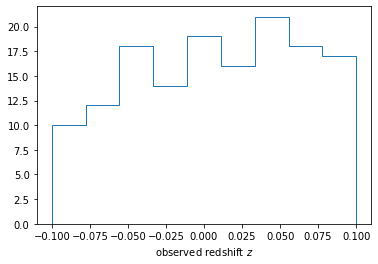

In [33]:
import matplotlib.pyplot as plt
bins = np.linspace(-0.1,0.1, 10)
plt.hist(data[:,1], bins=bins, histtype='step')
plt.xlabel(r'observed redshift $z$')
plt.show()